<a href="https://colab.research.google.com/github/vknalluri/TS/blob/main/Copy_of_LSTM_Google1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets load the required Libraries and the dataset.

In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

dataset=pd.read_csv("GOOGL.csv")
print("Number of rows and columns:", dataset.shape)
dataset.head(5)

Number of rows and columns: (3774, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,98.798798,101.921921,97.827827,101.456459,101.456459,31656712
1,2005-01-04,100.800804,101.566566,96.836838,97.347343,97.347343,27484288
2,2005-01-05,96.821823,98.548546,96.211212,96.851852,96.851852,16456727
3,2005-01-06,97.637634,98.048050,93.953957,94.369370,94.369370,20753426
4,2005-01-07,95.415413,97.222221,94.484482,97.022018,97.022018,19306474


Lets get the Descriptive Statistics.

In [3]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03
mean,505.671810,510.140559,500.828010,505.580766,505.580766,6.849096e+06
std,340.200096,342.818650,337.541716,340.316806,340.316806,7.664612e+06
min,87.737740,89.289291,86.371368,87.582581,87.582581,5.206000e+05
25%,242.516266,245.469223,240.380386,242.652649,242.652649,1.882950e+06
50%,333.788788,337.112106,329.894898,333.998992,333.998992,4.282713e+06
75%,748.687500,754.175003,740.242493,748.842484,748.842484,8.676315e+06
max,1364.000000,1367.050049,1353.000000,1362.469971,1362.469971,8.215117e+07


Lets check the variables and their datatypes.

df.info() shows that data type of Date is object. Hence we need to convert it into datetime datatype and index it.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3774 non-null   object 
 1   Open       3774 non-null   float64
 2   High       3774 non-null   float64
 3   Low        3774 non-null   float64
 4   Close      3774 non-null   float64
 5   Adj Close  3774 non-null   float64
 6   Volume     3774 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 206.5+ KB


In [5]:
dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

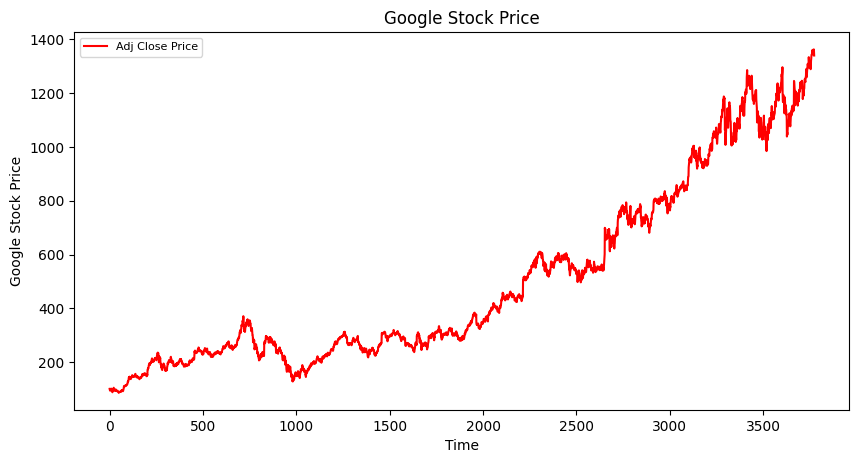

In [6]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(dataset['Adj Close'], color = 'red', label='Adj Close Price')
plt.title('Google Stock Price')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [7]:
import datetime

dataset['Date'] = pd.to_datetime(dataset.Date,format='%Y-%m-%d')
dataset.index = dataset['Date']
#plt.figure(figsize=(16,8))
#plt.plot(dataset['Volume'], label='Amount of Stocks')

dataset = dataset.sort_index(ascending=True, axis=0)
dataset2 = pd.DataFrame(index=range(0,len(dataset)),columns=['Date', 'Adj Close'])
for i in range(0,len(dataset)):
    dataset2['Date'][i] = dataset['Date'][i]
    dataset2['Adj Close'][i] = dataset['Adj Close'][i]
    
dataset2.index = dataset2.Date
dataset2.drop('Date', axis=1, inplace = True)

dataset3 = dataset2.values 

train = dataset3[0:3000, :]
valid = dataset3[3000:, :]
#print(valid)
valid.shape

(774, 1)

As sigmoid function that is used in the output layer of RNN always outputs values in the range of 0 to 1 , its better to normalize the input data such that normalized values are with in 0 to 1.

RNNs predict the prices based on windows of data or time stamps. For example, a time stamp of 20 means that RNN looks back for 10 entries to forecast next 10 entries. Reserach shows that ideal time stamp size is 60.

Lets create the feature inputs based on time stamp size of 60.

In [12]:
# puts everything between (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset3)
#print(scaled_data)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))




In [77]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 25, batch_size = 32)



Epoch 1/25
92/92 [==============================] - 15s 103ms/step - loss: 0.0040
Epoch 2/25
92/92 [==============================] - 9s 102ms/step - loss: 9.8345e-04
Epoch 3/25
92/92 [==============================] - 9s 101ms/step - loss: 8.1247e-04
Epoch 4/25
92/92 [==============================] - 9s 101ms/step - loss: 8.0907e-04
Epoch 5/25
92/92 [==============================] - 9s 102ms/step - loss: 7.2287e-04
Epoch 6/25
92/92 [==============================] - 9s 102ms/step - loss: 6.7553e-04
Epoch 7/25
92/92 [==============================] - 9s 103ms/step - loss: 7.1023e-04
Epoch 8/25
92/92 [==============================] - 10s 104ms/step - loss: 6.7117e-04
Epoch 9/25
92/92 [==============================] - 9s 103ms/step - loss: 6.1562e-04
Epoch 10/25
92/92 [==============================] - 9s 103ms/step - loss: 6.1647e-04
Epoch 11/25
92/92 [==============================] - 10s 106ms/step - loss: 5.3013e-04
Epoch 12/25
92/92 [==============================] - 9s 102ms/st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


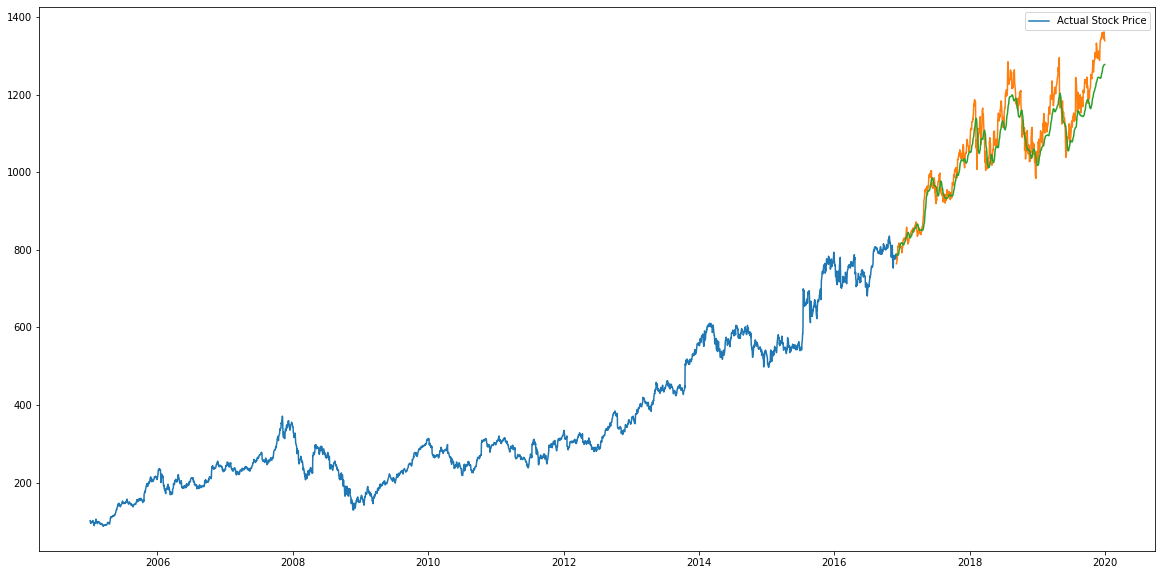

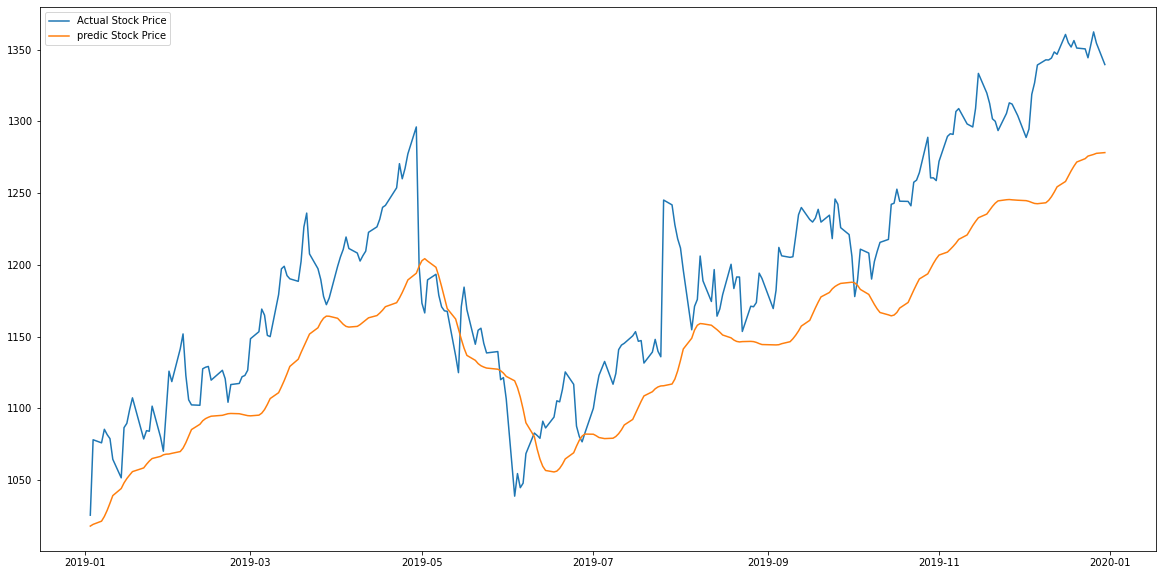

In [78]:
dataset_train = dataset2[:3000]
dataset_test = dataset2[3000:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)


X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
#print(X_test.shape)

train = dataset2[:3000]
valid = dataset2[3000:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10))
plt.plot(train['Adj Close'],label='Actual Stock Price')
plt.plot(valid[['Adj Close','Predictions']])
plt.legend()

valid1=valid['Predictions']
valid1_last=valid1[-250:]

valid2_last=dataset2[-250:]
valid3_last=dataset2[-774:]


train = dataset2[:3000]
valid = dataset2[3000:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10))
plt.plot(valid2_last['Adj Close'],label='Actual Stock Price')
plt.plot(valid1_last,label='predic Stock Price')
plt.legend()


In [79]:
from sklearn.metrics import mean_squared_error

err_LSTM = mean_squared_error(valid3_last['Adj Close'], closing_price ,squared =False) 
print('MSE with LSTM', err_LSTM)

MSE with LSTM 43.972671485169165
